In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
filepath = r'C:\Users\Huawei\Desktop\好一个大学\课内学习\大二下\应用统计学\hospital_infct.txt'
data = pd.read_csv(filepath, sep='\t')

### 多元线性回归模型
> 该模型整体是显著的(p=1.09e-10)，可解释36.3%的感染风险变异(R²=0.363)
其中住院天数最显著($eta$ = 0.3082),但可能有多重共线性的问题（条件数1280）

In [ ]:

# 提取变量
X = data[['Stay', 'Age', 'Xray']]  # 自变量：住院天数、年龄、X光检查量
y = data['InfctRsk']               # 因变量：感染风险

# 添加截距
X = sm.add_constant(X)

# 构建多元线性回归模型
model = sm.OLS(y, X).fit()

# 模型摘要（包含参数估计、假设检验结果）
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               InfctRsk   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     20.70
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           1.09e-10
Time:                        22:14:52   Log-Likelihood:                -167.51
No. Observations:                 113   AIC:                             343.0
Df Residuals:                     109   BIC:                             353.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0012      1.315      0.761      0.448      -1.605       3.607
Stay           0.3082      0.059      5.189      0.000       0.190       0.426
Age           -0.0230      0.024     -0.978      0.330      -0.070       0.024
Xray           0.0197      0.006      3.414      0.001       0.008       0.031
==============================================================================
Omnibus:                        0.750   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.687   Jarque-Bera (JB):                0.823
Skew:                           0.063   Prob(JB):                        0.663
Kurtosis:                       2.601   Cond. No.                     1.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 可视化
> 分析来看：感染风险和住院天数呈现轻微右上倾斜趋势，符合回归结果的正相关。感染风险和X光检查显示较明显的正相关趋势，点群向右上方延伸。感染风险和年龄点群分布杂乱，无明显趋势，印证年龄不显著。**总的来说**验证了回归分析结果，住院天数和X光检查与感染风险的存在正相关关系。但是年龄的影响确实不显著。需要注意的是右上角两个变量的轻微共线性趋势。

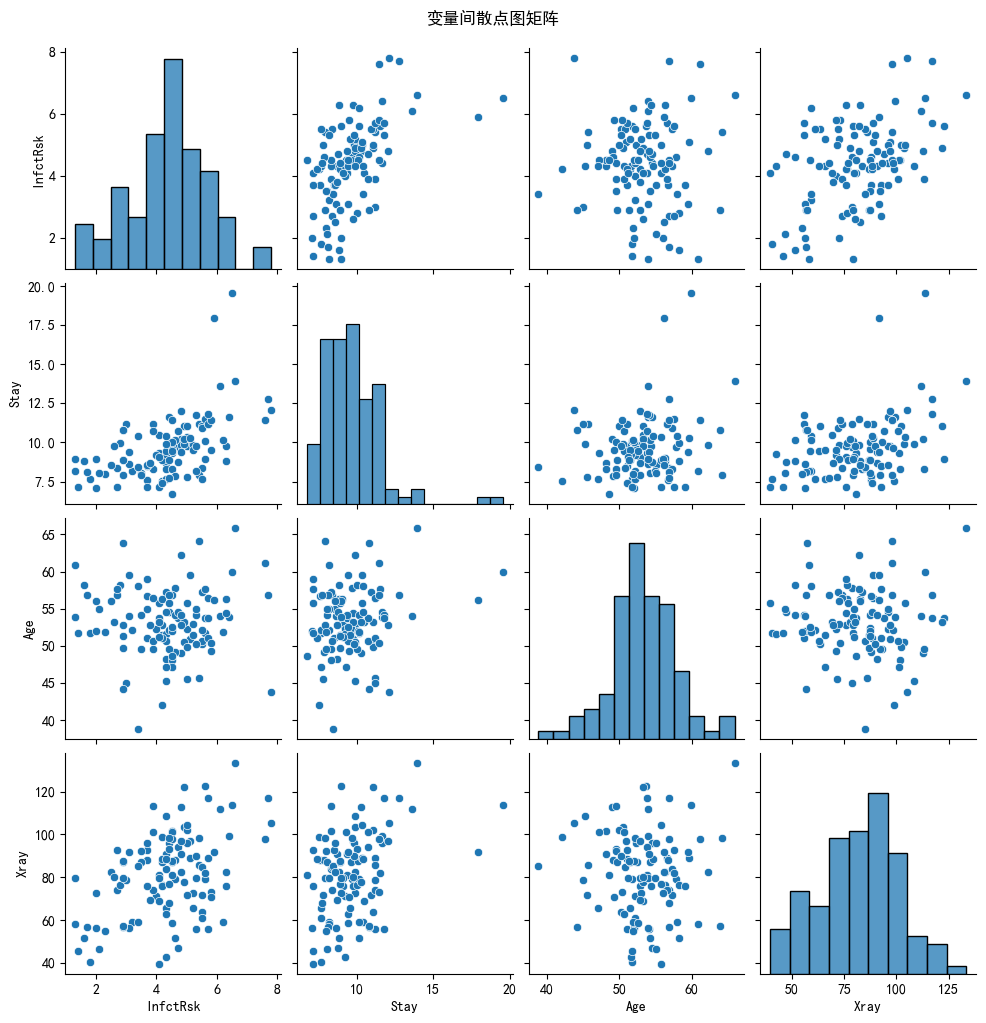

In [ ]:
# 绘制散点图矩阵
sns.pairplot(data[['InfctRsk', 'Stay', 'Age', 'Xray']])
plt.suptitle('变量间散点图矩阵', y=1.02)
plt.show()

### 相关性分析
> 根据热力图：感染风险与住院天数相关性最强(r=0.53)，与X光检查中等相关(r=0.45)，而与患者年龄几乎无关(r=0.00)。但是住院天数与X光检查存在一定关联(r=0.38)，可能有多重共线性的问题。
年龄与其他变量均无明显相关性(<0.2)。整体来看，住院天数是预测感染风险的最关键因素，X光检查次之，年龄没有预测价值。

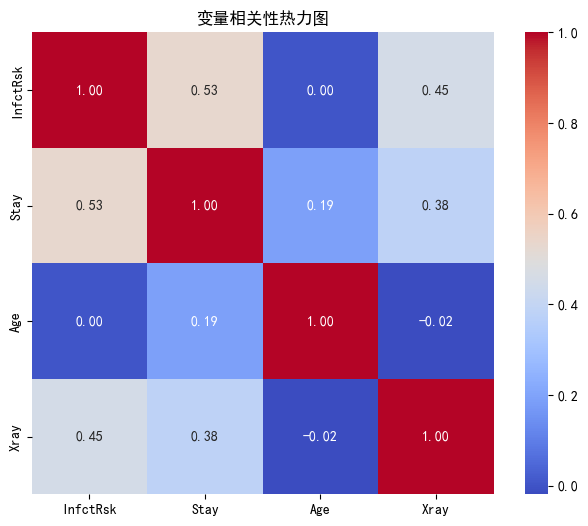

In [4]:
# 计算相关系数矩阵
correlation = data[['InfctRsk', 'Stay', 'Age', 'Xray']].corr()

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('变量相关性热力图')
plt.show()

### 多重共线性检验
- VIF > 5：存在较强多重共线性
- VIF > 10：严重多重共线性，需处理

> 根据结果可知 均不存在严重多重共线性

In [ ]:
# 计算方差膨胀因子(VIF)，检测多重共线性
vif_data = pd.DataFrame()
vif_data["变量"] = X.columns[1:]  # 跳过常数项
vif_data["VIF"] = [variance_inflation_factor(X.values, i+1) for i in range(len(X.columns)-1)]

print("\n多重共线性检验 (VIF):")
print(vif_data)
#


多重共线性检验 (VIF):
     变量       VIF
0  Stay  1.226650
1   Age  1.047573
2  Xray  1.183293


### 残差分析
> 从残差分析结果来看，残差正态性检验的统计量p=0.9037,大于常用显著性水平（如0.05），表明残差服从正态分布，满足多元线性回归关于残差正态性的假设.


残差正态性检验: W=0.9939, p=0.9037


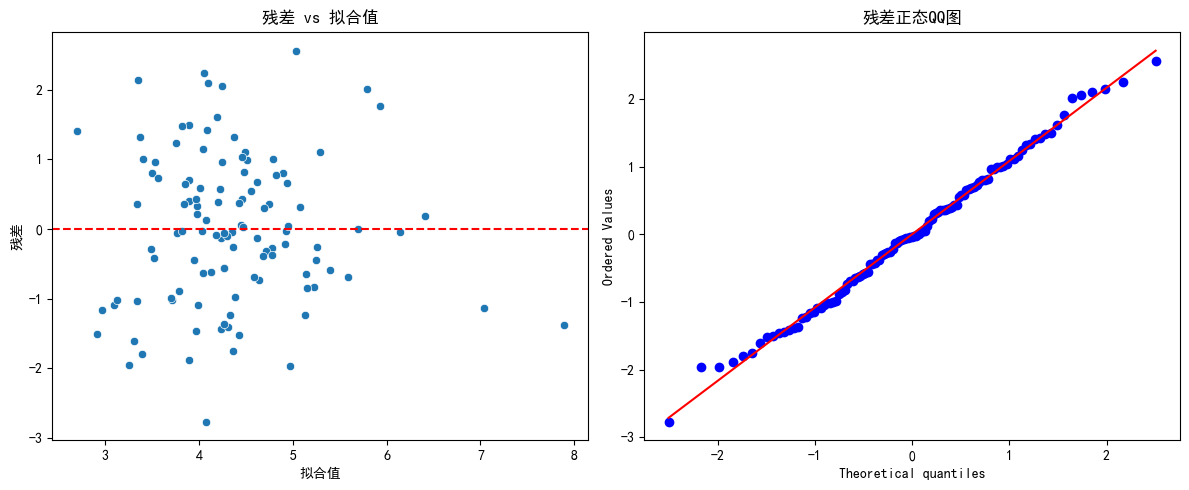

In [6]:
# 获取残差
residuals = model.resid

# 残差正态性检验 (Shapiro-Wilk)
shapiro_test = stats.shapiro(residuals)
print(f"\n残差正态性检验: W={shapiro_test[0]:.4f}, p={shapiro_test[1]:.4f}")

# 残差图可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 残差-拟合值散点图（检验同方差性）
sns.scatterplot(x=model.fittedvalues, y=residuals, ax=axes[0])
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_title('残差 vs 拟合值')
axes[0].set_xlabel('拟合值')
axes[0].set_ylabel('残差')

# 残差正态QQ图（检验正态性）
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('残差正态QQ图')

plt.tight_layout()
plt.show()

### 预测

In [7]:
# 预测新数据点的感染风险
new_data = pd.DataFrame({
    'const': [1],           # 常数项
    'Stay': [8.5],          # 住院天数
    'Age': [55],            # 年龄
    'Xray': [200]           # X光检查量
})

# 预测并打印结果
predicted_risk = model.predict(new_data)
print(f"\n预测感染风险: {predicted_risk[0]:.4f}")


预测感染风险: 6.2876
